In [26]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import AlignedUMAP
from sklearn.cluster import KMeans
import seaborn as sns
import random
from sklearn.metrics import silhouette_score

In [27]:
seed = 1
random.seed(seed)
np.random.seed(seed)

In [28]:
data = pd.read_csv("simulated_symptom_data.csv")

symptom_data = data.drop(columns=['Age', 'SymptomCount_T1', 'FullPersistence']) #columns for L-VAE

#split dataset into t1 and t2

symptom_data_t1 = symptom_data.iloc[:, :12]  #symptoms at timepoint 1
symptom_data_t2 = symptom_data.iloc[:, 12:]  #symptoms at timepoint 2



In [29]:
#transposing dataframe to have shape (n_symptoms x n_individuals)
X_t1 = symptom_data_t1.T.values
X_t2 = symptom_data_t2.T.values

#combine into one list
X_list = [X_t1, X_t2]

#identity relation: aligning symptom i at t1 with symptom i at t2
relations = [{i: i for i in range(X_t1.shape[0])}]

#fitting Aligned UMAP
aligned_mapper = AlignedUMAP(
    n_neighbors=5,
    min_dist=0.1,
    n_components=2,
    random_state=seed
)
aligned_embedding = aligned_mapper.fit_transform(X_list, relations=relations)

#split embeddings across time points
embedding_t1, embedding_t2 = aligned_embedding



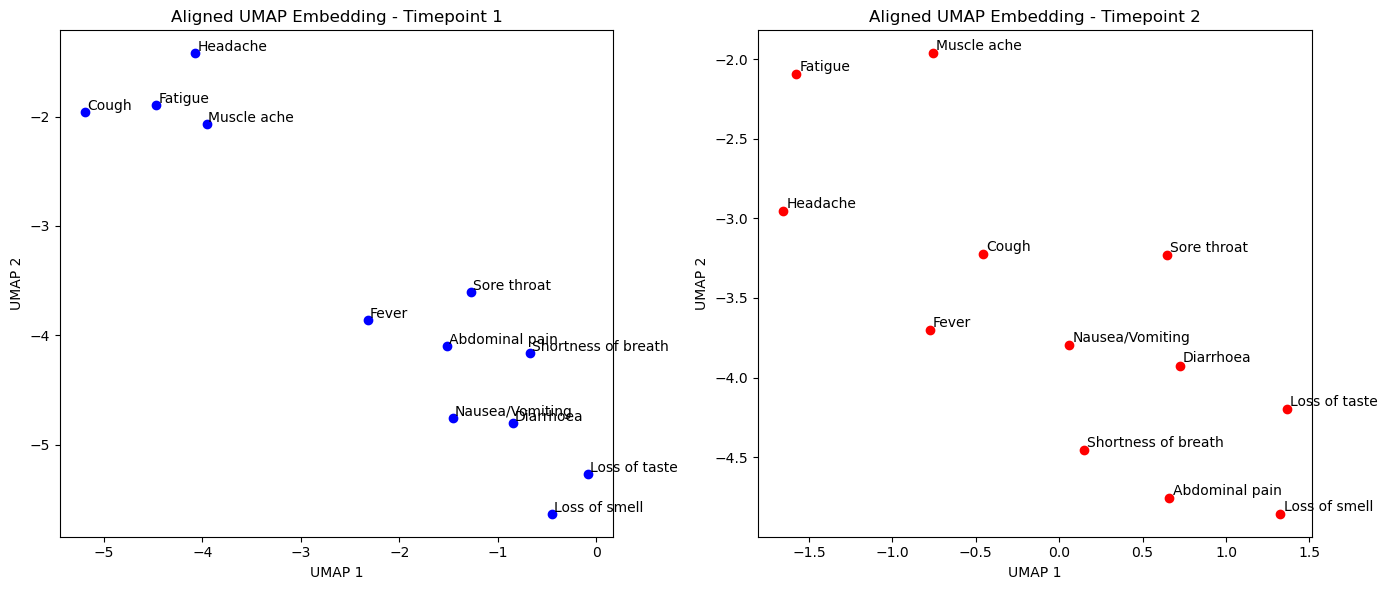

In [30]:
#getting symptom names for plot(in the order used for embedding)

symptom_labels = [label for label in symptom_data_t1.columns]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

#timepoint 1
axs[0].scatter(embedding_t1[:, 0], embedding_t1[:, 1], color='blue')
for i, label in enumerate(symptom_labels):
    axs[0].text(embedding_t1[i, 0] + 0.02, embedding_t1[i, 1] + 0.02, label, fontsize=10)
axs[0].set_title('Aligned UMAP Embedding - Timepoint 1')
axs[0].set_xlabel('UMAP 1')
axs[0].set_ylabel('UMAP 2')

#timepoint 2
axs[1].scatter(embedding_t2[:, 0], embedding_t2[:, 1], color='red')
for i, label in enumerate(symptom_labels):
    axs[1].text(embedding_t2[i, 0] + 0.02, embedding_t2[i, 1] + 0.02, label, fontsize=10)
axs[1].set_title('Aligned UMAP Embedding - Timepoint 2')
axs[1].set_xlabel('UMAP 1')
axs[1].set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()


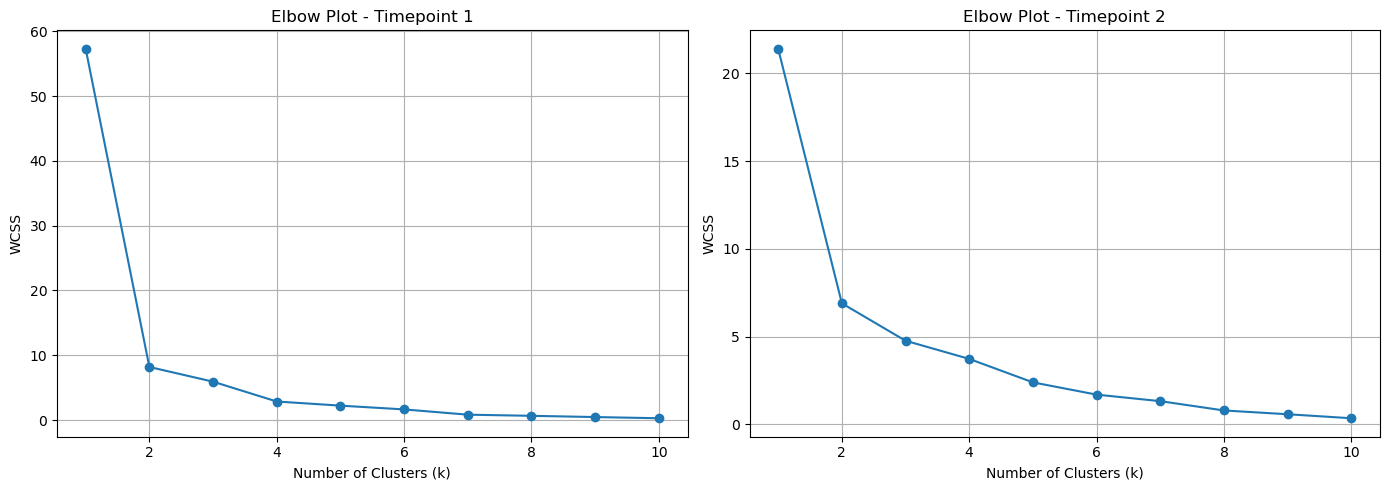

In [31]:
#creating elbow plots to determine optimal value of k

#setting range of k values
k_values = range(1, 11)
wcss_t1 = []
wcss_t2 = []

#elbow plot for timepoint 1
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(embedding_t1)
    wcss_t1.append(kmeans.inertia_)

#elbow plot for timepoint 2
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(embedding_t2)
    wcss_t2.append(kmeans.inertia_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#t1 plot
axes[0].plot(k_values, wcss_t1, marker='o')
axes[0].set_title('Elbow Plot - Timepoint 1')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('WCSS')
axes[0].grid(True)

#t2 plot
axes[1].plot(k_values, wcss_t2, marker='o')
axes[1].set_title('Elbow Plot - Timepoint 2')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('WCSS')
axes[1].grid(True)

plt.tight_layout()
plt.show()


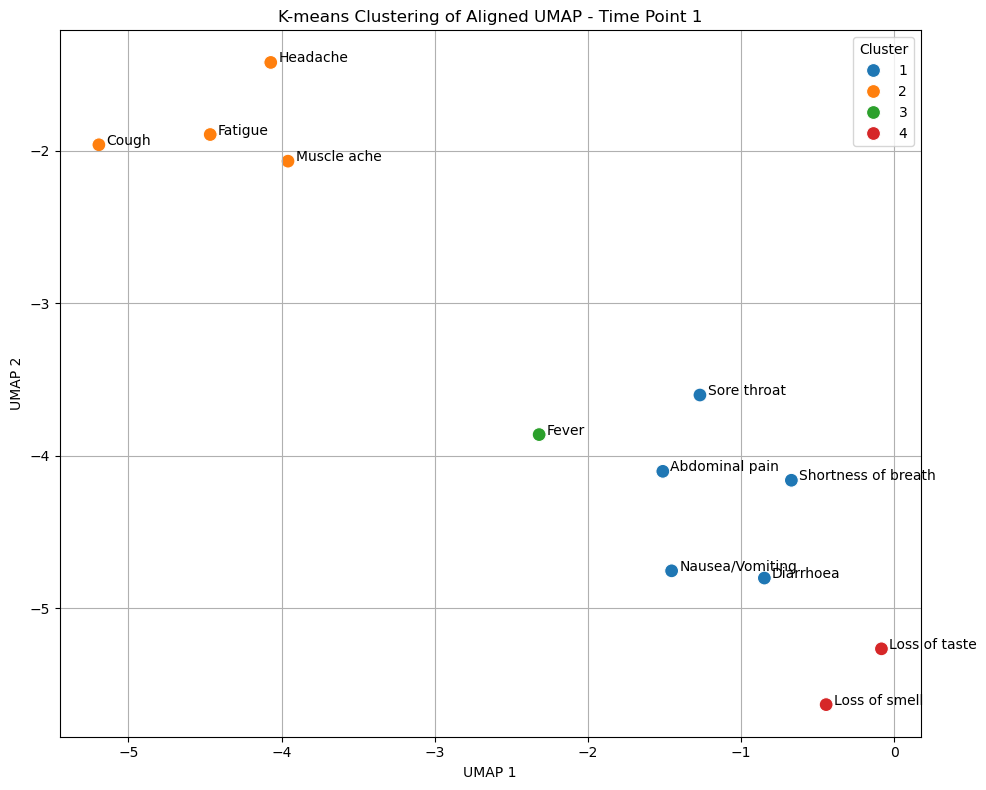

In [32]:
#K-means for time point 1
n_clusters = 4
kmeans_t1 = KMeans(n_clusters=n_clusters, random_state=seed)
labels_t1 = kmeans_t1.fit_predict(embedding_t1)
labels_t1 = labels_t1 + 1

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedding_t1[:, 0], y=embedding_t1[:, 1], hue=labels_t1, palette="tab10", s=100)
for i, label in enumerate(symptom_labels):
    plt.text(embedding_t1[i, 0] + 0.05, embedding_t1[i, 1], label, fontsize=10)
plt.title("K-means Clustering of Aligned UMAP - Time Point 1")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()



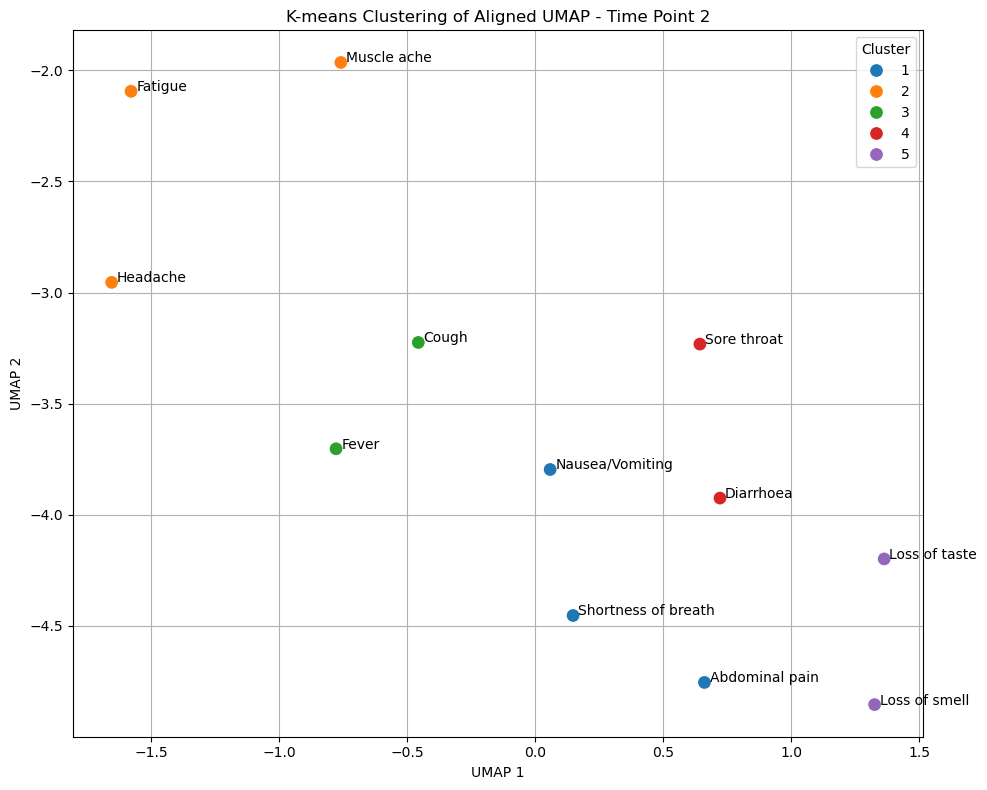

In [42]:
#K-means for Time Point 2
n_clusters=5
kmeans_t2 = KMeans(n_clusters=n_clusters, random_state=seed)
labels_t2 = kmeans_t2.fit_predict(embedding_t2)
labels_t2 = labels_t2 + 1

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedding_t2[:, 0], y=embedding_t2[:, 1], hue=labels_t2, palette="tab10", s=100)
for i, label in enumerate(symptom_labels):
    plt.text(embedding_t2[i, 0] + 0.02, embedding_t2[i, 1], label, fontsize=10)
plt.title("K-means Clustering of Aligned UMAP - Time Point 2")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
df_clusters_t1 = pd.DataFrame({'Symptom': symptom_labels, 'Cluster_T1': labels_t1})

#sort dataframe by cluster number
df_clusters_t1_sorted = df_clusters_t1.sort_values(by='Cluster_T1').reset_index(drop=True)

print("Cluster Assignments at time point 1")
print(df_clusters_t1_sorted.to_string(index=False))



Cluster Assignments at time point 1
            Symptom  Cluster_T1
        Sore throat           1
Shortness of breath           1
    Nausea/Vomiting           1
     Abdominal pain           1
          Diarrhoea           1
        Muscle ache           2
            Fatigue           2
              Cough           2
           Headache           2
              Fever           3
      Loss of taste           4
      Loss of smell           4


In [44]:
df_clusters_t2 = pd.DataFrame({'Symptom': symptom_labels, 'Cluster_T2': labels_t2})

df_clusters_t2_sorted = df_clusters_t2.sort_values(by='Cluster_T2').reset_index(drop=True)

print("Cluster Assignments at time point 2")

print(df_clusters_t2_sorted.to_string(index=False))

Cluster Assignments at time point 2
            Symptom  Cluster_T2
Shortness of breath           1
    Nausea/Vomiting           1
     Abdominal pain           1
        Muscle ache           2
            Fatigue           2
           Headache           2
              Fever           3
              Cough           3
        Sore throat           4
          Diarrhoea           4
      Loss of taste           5
      Loss of smell           5


Silhouette (T1, k=4): 0.4297199
Silhouette (T2, k=5): 0.2792055


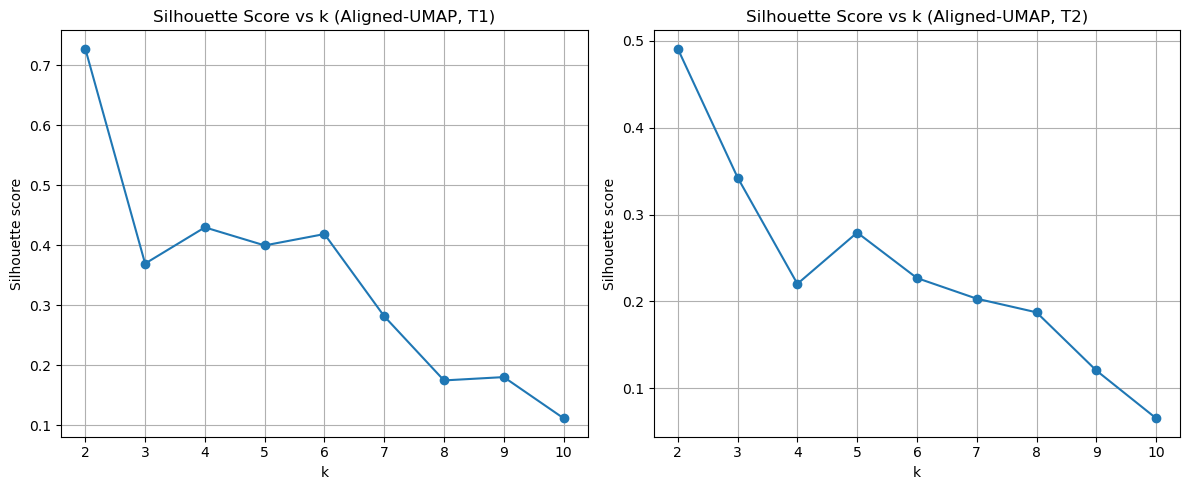

In [45]:
#choose k range (silhouette requires k >= 2)
k_values = range(2, 11)
random_state = seed

#silhouette scores
sil_t1 = []
sil_t2 = []

for k in k_values:
    km1 = KMeans(n_clusters=k, random_state=random_state)
    labels1 = km1.fit_predict(embedding_t1)
    sil_t1.append(silhouette_score(embedding_t1, labels1))

    km2 = KMeans(n_clusters=k, random_state=random_state)
    labels2 = km2.fit_predict(embedding_t2)
    sil_t2.append(silhouette_score(embedding_t2, labels2))

sil_t1 = np.array(sil_t1)
sil_t2 = np.array(sil_t2)

km1 = KMeans(n_clusters=4, random_state=seed).fit(embedding_t1)
print("Silhouette (T1, k=4):", silhouette_score(embedding_t1, km1.labels_))
km2 = KMeans(n_clusters=5, random_state=seed).fit(embedding_t2)
print("Silhouette (T2, k=5):", silhouette_score(embedding_t2, km2.labels_))


#plot silhouette curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(k_values), sil_t1, marker='o')
plt.title('Silhouette Score vs k (Aligned-UMAP, T1)')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.xticks(list(k_values))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(k_values), sil_t2, marker='o')
plt.title('Silhouette Score vs k (Aligned-UMAP, T2)')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.xticks(list(k_values))
plt.grid(True)

plt.tight_layout()
plt.show()

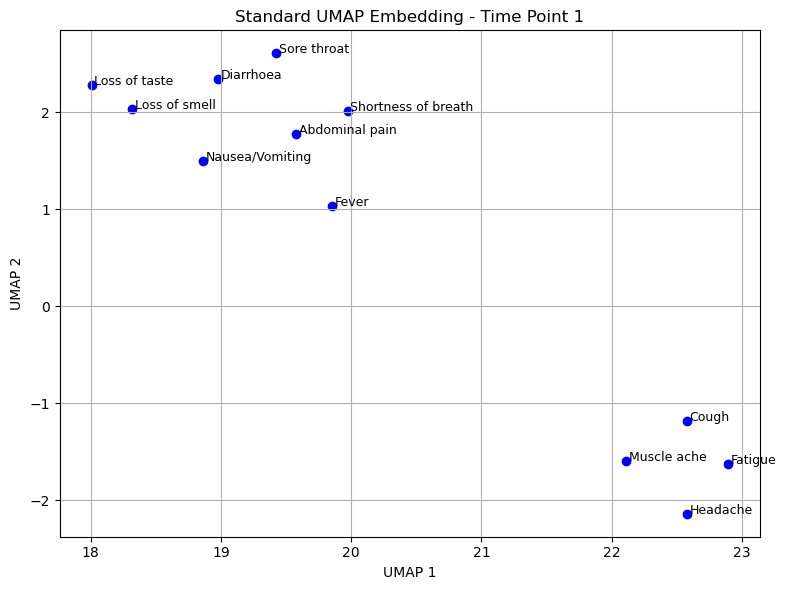

In [46]:
#standard UMAP embedding

umap_model = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1,
    n_components=2,
    random_state=1
)
embedding_t1_umap = umap_model.fit_transform(X_t1)


plt.figure(figsize=(8, 6))
plt.scatter(embedding_t1_umap[:, 0], embedding_t1_umap[:, 1], color='blue')
for i, label in enumerate(symptom_labels):
    plt.text(embedding_t1_umap[i, 0] + 0.02, embedding_t1_umap[i, 1], label, fontsize=9)
plt.title("Standard UMAP Embedding - Time Point 1")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()


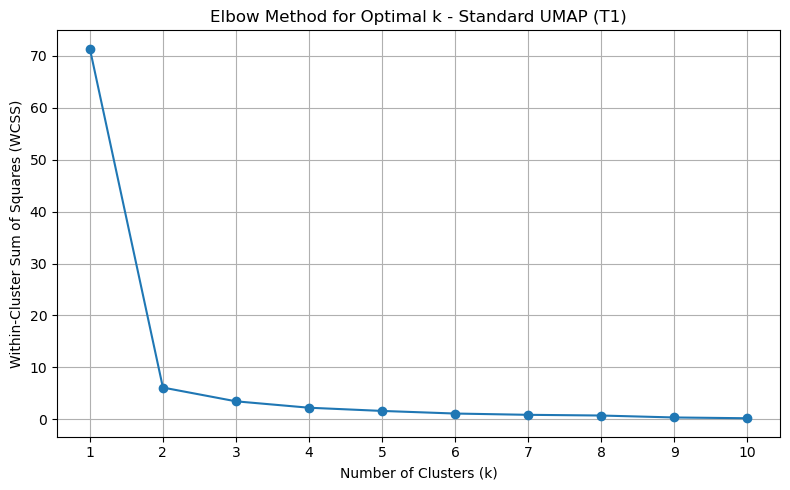

In [47]:
#elbow plot
k_values = range(1, 11)
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(embedding_t1_umap)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal k - Standard UMAP (T1)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

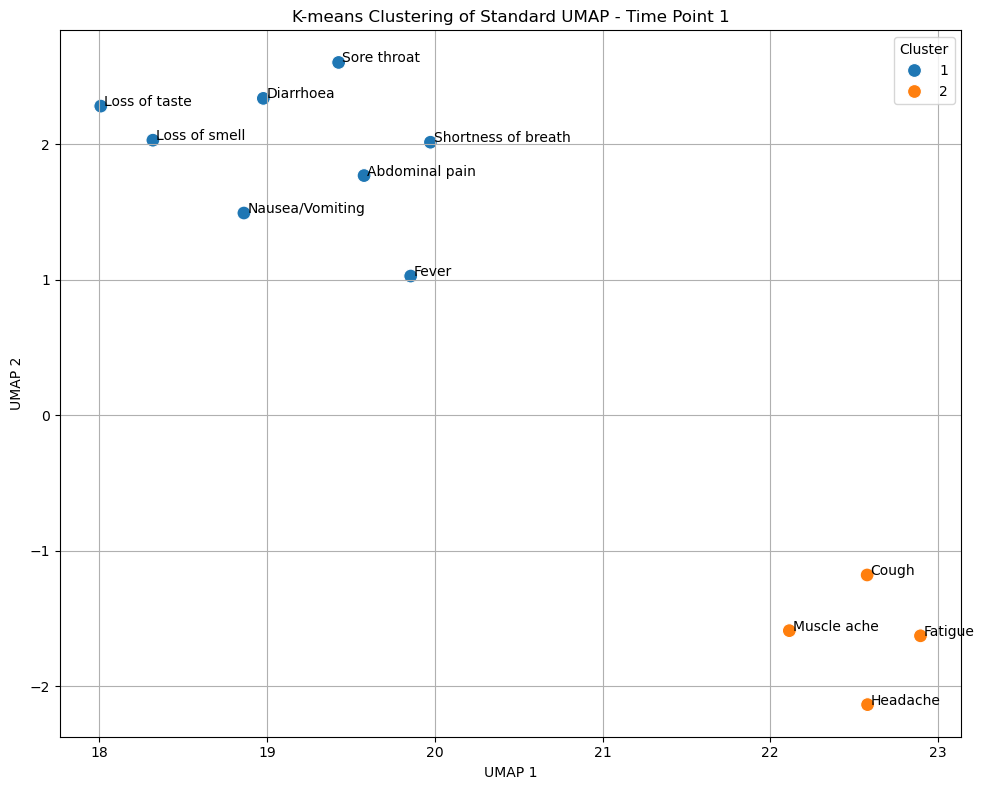

In [48]:
#K-means
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
labels = kmeans.fit_predict(embedding_t1_umap)
labels = labels + 1  #makes cluster labels start from 1

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding_t1_umap[:, 0],
    y=embedding_t1_umap[:, 1],
    hue=labels,
    palette="tab10",
    s=100
)
for i, lbl in enumerate(symptom_labels):
    plt.text(embedding_t1_umap[i, 0] + 0.02, embedding_t1_umap[i, 1], lbl, fontsize=10)

plt.title("K-means Clustering of Standard UMAP - Time Point 1")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.legend(title="Cluster", loc="best")
plt.grid(True); plt.tight_layout(); plt.show()



In [49]:
symptom_clusters_t1 = (
    pd.DataFrame({"Symptom": symptom_labels, "Cluster": labels})
      .sort_values("Cluster")
      .reset_index(drop=True)
)
print(symptom_clusters_t1)

                Symptom  Cluster
0                 Fever        1
1           Sore throat        1
2   Shortness of breath        1
3       Nausea/Vomiting        1
4        Abdominal pain        1
5             Diarrhoea        1
6         Loss of taste        1
7         Loss of smell        1
8           Muscle ache        2
9               Fatigue        2
10                Cough        2
11             Headache        2


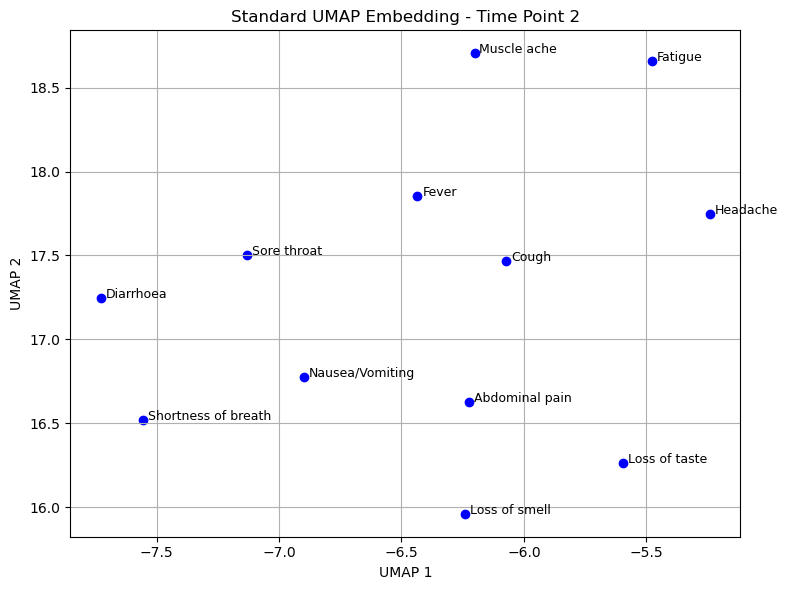

In [50]:
#UMAP time point 2

umap_model = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1,
    n_components=2,
    random_state=1
)
embedding_t2_umap = umap_model.fit_transform(X_t2)


plt.figure(figsize=(8, 6))
plt.scatter(embedding_t2_umap[:, 0], embedding_t2_umap[:, 1], color='blue')
for i, label in enumerate(symptom_labels):
    plt.text(embedding_t2_umap[i, 0] + 0.02, embedding_t2_umap[i, 1], label, fontsize=9)
plt.title("Standard UMAP Embedding - Time Point 2")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()


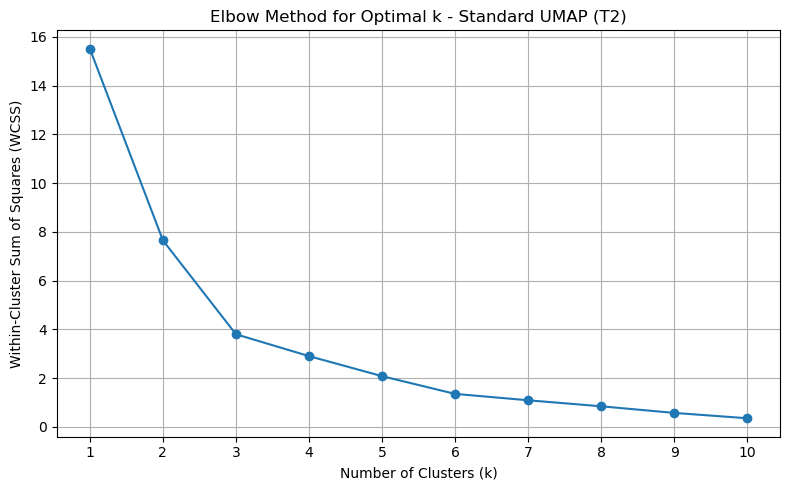

In [51]:
#elbow plot
k_values = range(1, 11)
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(embedding_t2_umap)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal k - Standard UMAP (T2)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

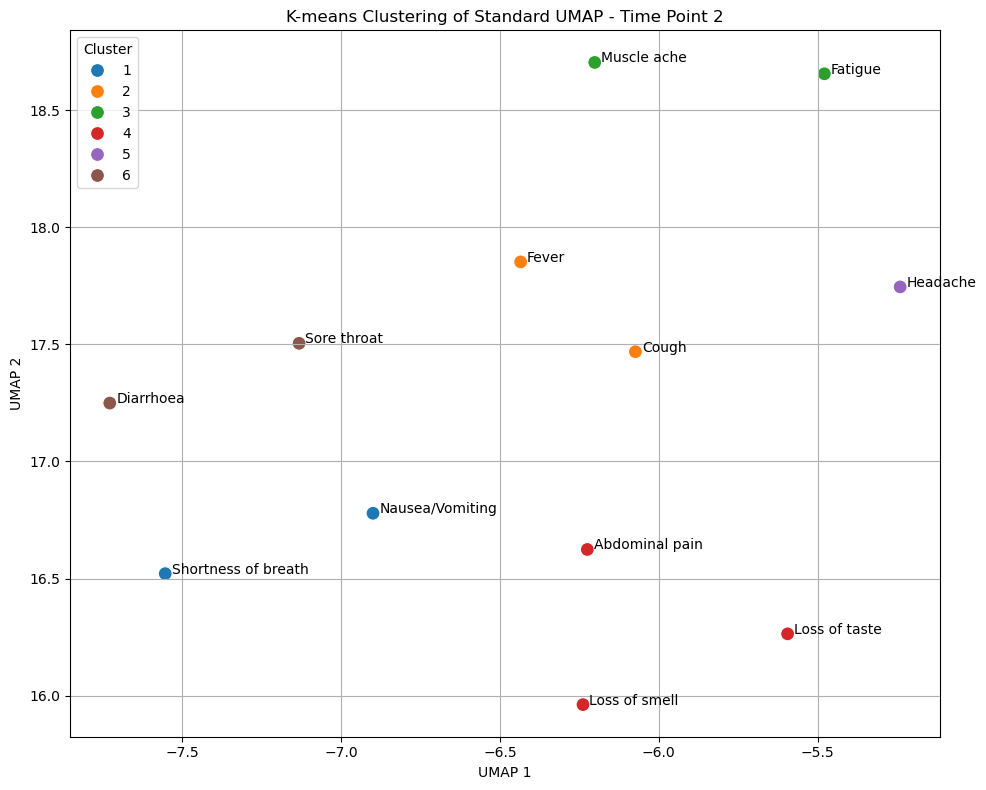

In [58]:
#K-means clustering
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
labels = kmeans.fit_predict(embedding_t2_umap)
labels = labels + 1  #cluster labels starting from 1 rather than 0

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding_t2_umap[:, 0],
    y=embedding_t2_umap[:, 1],
    hue=labels,
    palette="tab10",
    s=100
)
for i, lbl in enumerate(symptom_labels):
    plt.text(embedding_t2_umap[i, 0] + 0.02, embedding_t2_umap[i, 1], lbl, fontsize=10)

plt.title("K-means Clustering of Standard UMAP - Time Point 2")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.legend(title="Cluster", loc="best")
plt.grid(True); plt.tight_layout(); plt.show()

In [53]:
symptom_clusters_t2 = (
    pd.DataFrame({"Symptom": symptom_labels, "Cluster": labels})
      .sort_values("Cluster")
      .reset_index(drop=True)
)
print(symptom_clusters_t2)

                Symptom  Cluster
0   Shortness of breath        1
1       Nausea/Vomiting        1
2                 Fever        2
3                 Cough        2
4           Muscle ache        3
5               Fatigue        3
6        Abdominal pain        4
7         Loss of taste        4
8         Loss of smell        4
9              Headache        5
10          Sore throat        6
11            Diarrhoea        6


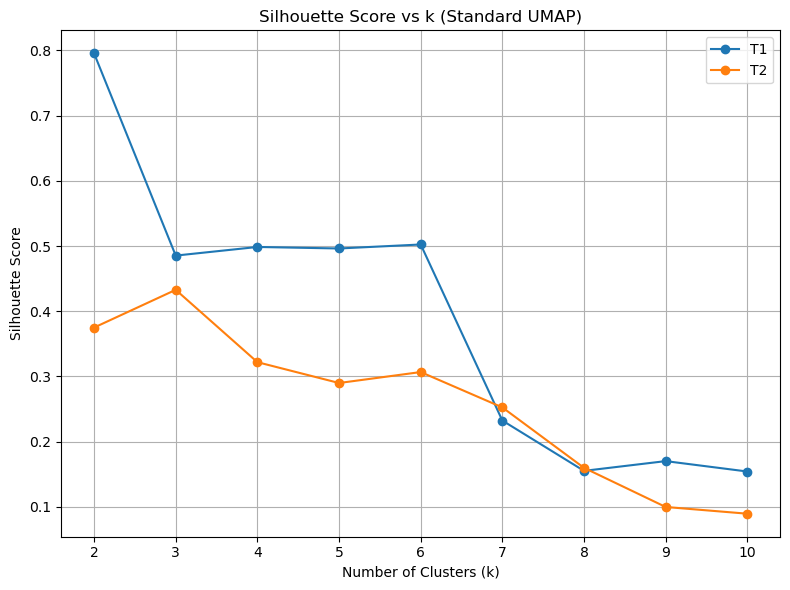

In [54]:
#range of K values for silhouette scores plot
k_values = range(2, 11)
sil_scores_t1 = []
sil_scores_t2 = []

for k in k_values:
    km1 = KMeans(n_clusters=k, random_state=1)
    labels_t1 = km1.fit_predict(embedding_t1_umap)
    sil_scores_t1.append(silhouette_score(embedding_t1_umap, labels_t1))

    km2 = KMeans(n_clusters=k, random_state=1)
    labels_t2 = km2.fit_predict(embedding_t2_umap)
    sil_scores_t2.append(silhouette_score(embedding_t2_umap, labels_t2))

#plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, sil_scores_t1, marker='o', label='T1')
plt.plot(k_values, sil_scores_t2, marker='o', label='T2')
plt.title("Silhouette Score vs k (Standard UMAP)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [55]:
k_t1 = 2
km_t1 = KMeans(n_clusters=k_t1, random_state=1)
labels_t1_k2 = km_t1.fit_predict(embedding_t1_umap)
sil_t1_k2 = silhouette_score(embedding_t1_umap, labels_t1_k2)
print(f"Silhouette Score (T1, k={k_t1}): {sil_t1_k2:.3f}")

k_t2 = 6
km_t2 = KMeans(n_clusters=k_t2, random_state=1)
labels_t2_k5 = km_t2.fit_predict(embedding_t2_umap)
sil_t2_k5 = silhouette_score(embedding_t2_umap, labels_t2_k5)
print(f"Silhouette Score (T2, k={k_t2}): {sil_t2_k5:.3f}")


Silhouette Score (T1, k=2): 0.796
Silhouette Score (T2, k=6): 0.307
